In [208]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import math

In [209]:
# 读取数据，pd.read_csv默认生成DataFrame对象，需将其转换成Series对象
df_ori = pd.read_csv('../../dataset/MA-year.csv',header=0)
df_ori.index = pd.to_datetime(df_ori['Date'])  # 将字符串索引转换成时间索引
#df=df_ori.asfreq(freq='3d',method='ffill')
df_ori.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2018-02-08,2018-02-08,168.770004,169.240005,160.460007,160.619995,159.505783,6557700
2018-02-09,2018-02-09,161.669998,166.490005,158.570007,165.199997,164.054016,6303000
2018-02-12,2018-02-12,166.800003,168.820007,165.580002,168.190002,167.023285,5227400
2018-02-13,2018-02-13,167.330002,170.770004,167.009995,170.119995,168.939896,3471000
2018-02-14,2018-02-14,169.360001,172.660004,169.000000,172.520004,171.323257,4203700


In [210]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
sc_close=sc.fit_transform(df_ori['Close'].values.reshape(-1,1))

In [211]:
def data_to_x_y(data,n_in_steps,n_out_steps):
    X_data,y_data=[],[]
    for i in range(0,data.shape[0]-n_in_steps-n_out_steps):
        X_data.append(data[i:i+n_in_steps])
        y_data.append(data[i+n_in_steps+n_out_steps-1])
    X_data=np.array(X_data)
    y_data=np.array(y_data)
    #X_data=X_data.reshape(X_train.shape[0],X_train.shape[1],1)
    #y_data=y_data.reshape(y_train.shape[0],1)
    return X_data,y_data

In [212]:
X_train,y_train=data_to_x_y(sc_close,5,1)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1])
y_train=y_train.reshape(y_train.shape[0])
print(X_train.shape)
print(y_train.shape)

(246, 5)
(246,)


In [213]:
#SVR Model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)
rbf_fit = svr_rbf.fit(X_train, y_train)
# lin_fit = svr_lin.fit(X_train,y_train)
# poly_fit = svr_poly.fit(X_train, y_train)

In [214]:
from dateutil.relativedelta import relativedelta
timestamp=5
days=60

In [215]:
sc_close[-timestamp:].shape
np.transpose(sc_close[-timestamp:]).shape
X=sc_close[-timestamp:].reshape(-1)
print(X)

[0.85969915 0.87474265 0.8658749  0.84481391 0.88614409]


In [216]:
predictions=list()
X=sc_close[-timestamp:].reshape(-1)
for i in range(days):
    trainX=X[-timestamp:].reshape(-1,1)
    #print(trainX)
    yhat=rbf_fit.predict(np.transpose(trainX))
    #print(yhat)
    X=np.append(X,yhat[0])
    sc_close=np.append(sc_close,yhat[0])
    predictions.append(yhat[0])

In [217]:
print(sc_close.shape)
inv_yhat=sc.inverse_transform(sc_close.reshape(-1,1))

(312,)


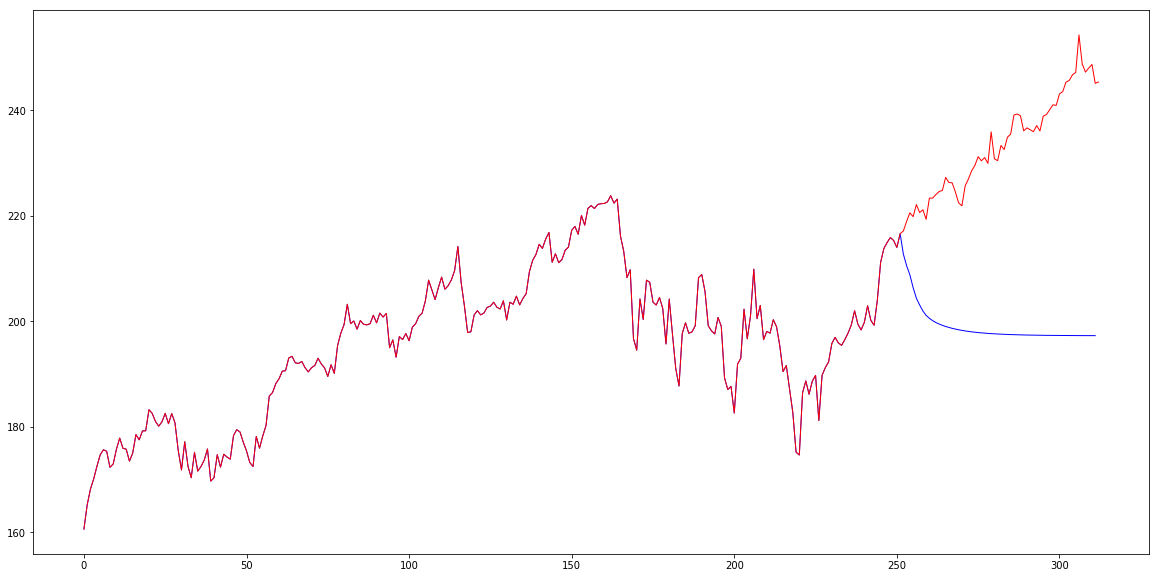

In [218]:
df_all=pd.read_csv('../../dataset/MA-year-now.csv',header=0)
df_all_close=df_all['Close']
plt.figure(figsize=(20,10))
plt.plot(inv_yhat,color='blue',lw=1,label='prediction')
plt.plot(df_all_close.values,color='red',lw=1,label='Origin')
plt.show()

In [219]:
#误差统计
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
pre=inv_yhat[-days:]
ori=df_all_close.values[inv_yhat.shape[0]-days:inv_yhat.shape[0]]
print(pre.shape)
print(ori.shape)
avg=np.mean(ori)

rmse=math.sqrt(mean_squared_error(pre, ori))
mae=mean_absolute_error(pre,ori)

rmse_error_percentage=rmse/avg
mae_error_percentage=mae/avg
print('TEST RMSE: %.4f' % rmse)
print('TEST MAE: %.4f'% mae)
print("Test RMSE Error Percentage: %.2f/100.00" % (rmse_error_percentage * 100))
print("Test MAE Error Percentage: %.2f/100.00" % (mae_error_percentage * 100))

(60, 1)
(60,)
TEST RMSE: 36.2142
TEST MAE: 34.2730
Test RMSE Error Percentage: 15.53/100.00
Test MAE Error Percentage: 14.70/100.00
